In [39]:
# %pip install pyinstrument opencv-python numpy mediapipe

In [40]:
%load_ext pyinstrument
%load_ext autoreload
%autoreload 2

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import winsound
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"
import cv2

from hand_task import HAND_TASK
from cell_phone_task import CELL_PHONE_TASK
from head_task import HEAD_DIRECTION_TASK
from iris_task import IRIS_TASK
import time

iris_task = IRIS_TASK()
cell_phone_task = CELL_PHONE_TASK()
head_dir_task  = HEAD_DIRECTION_TASK()
hand_task = HAND_TASK()
tasks = [iris_task.process, cell_phone_task.process, head_dir_task.process, hand_task.process]

In [ ]:
import threading, winsound

class InstanceSound:
    def __init__(self, wav_path):
        self.wav_path = wav_path
        self.sound_thread = None
        self.queue_to_move_back = False
    
    def __hash__(self): 
        # TODO: crashs maybe happen, but just-work in this case
        return ord(self.wav_path[0])
    
    def __repr__(self):
        return self.wav_path
    
    def thread_generator(self):
        play_blocking = lambda: winsound.PlaySound(self.wav_path, winsound.SND_FILENAME)  # blocks until finished
        return threading.Thread(target=play_blocking)

    def set_on(self):
        if not(self.is_alive()):
            self.sound_thread = self.thread_generator()
            self.sound_thread.start()
            self.queue_to_move_back = True
    
    def is_alive(self):
        return (
            self.sound_thread.is_alive() or
            self.sound_thread is None
        )

class WinSoundController:
    def __init__(self, wav_path_list: str):
        self.all_sound_instance = [InstanceSound(path) for path in wav_path_list]
        self.playlist = []

    def current_flag(self, result_flag):
        current_wanted_play_sound = [self.all_sound_instance[i] for i in range(len(result_flag)) if result_flag[i]]
        need_to_add = set(current_wanted_play_sound) - set(self.playlist)

        need_to_remove = set(self.playlist) - set(current_wanted_play_sound)
        if len(self.playlist) > 0:
            top_queue = self.playlist[0]
            if top_queue.is_alive() or top_queue.queue_to_move_back:
                need_to_remove -= set([top_queue])
        
        self.playlist = list(set(self.playlist) - set(need_to_remove)) + list(need_to_add)

        if len(self.playlist) == 0:
            return
        
        top_queue = self.playlist[0]
        if not(top_queue.queue_to_move_back):
            top_queue.set_on()
        if not(top_queue.is_alive()):
            top_queue.queue_to_move_back = False
            self.playlist.append(self.playlist.pop(0))
    
def add_label(res):
    label = res[1]
    color = (0,0,255) if res[0] else (255,0,0)  # keep your colors
    cv2.putText(res[2], label, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return res[2]

c:\oit\py25en\source\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


_     ._   __/__   _ _  _  _ _/_   Recorded: 13:59:35  Samples:  6387
 /_//_/// /_\ / //_// / //_'/ //     Duration: 35.873    CPU time: 24.609
/   _/                      v5.1.1

Cell [87]

35.871 <module>  ..\..\..\Temp\ipykernel_21380\3831031488.py:1
|- 27.701 Future.result  concurrent\futures\_base.py:428
|  `- 27.696 Condition.wait  threading.py:323
|     `- 27.693 lock.acquire  <built-in>
|- 2.709 [self]  ..\..\..\Temp\ipykernel_21380\3831031488.py
|- 2.561 waitKey  <built-in>
|- 1.285 VideoCapture.read  <built-in>
`- 0.556 imshow  <built-in>
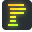

In [87]:
%%pyinstrument
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

list_fps = []

# Use a WAV file for reliable start/stop control
sound = WinSoundController(
    wav_path_list = [
        './sounds/eyes.wav',
        './sounds/phone.wav',
        './sounds/head.wav',
        './sounds/steering.wav'
    ]
)
verbose = True

with ThreadPoolExecutor(max_workers=len(tasks)) as pool:
    while cap.isOpened():
        start_time = time.time()
        ret, frame = cap.read()
        if not ret:
            break

        futures = [pool.submit(func, frame.copy()) for func in tasks]
        results = [f.result() for f in futures]
        
        # results = [
        #     func(frame.copy()) for func in tasks
        # ]

        # --- SOUND LOGIC: play once while any alert is True; stop when all False ---
        # bad_flag = any(res[0] for res in results)
        # sound.set_on(bad_flag)
        
        sound.current_flag([res[0] for res in results])

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

        time_usage =  time.time() - start_time
        list_fps.append(time_usage)
        if len(list_fps) > 60:
            del list_fps[0]

        if verbose:
            concat_images = [add_label(res) for res in results]
            result_image = np.concatenate(
                (
                    np.concatenate((concat_images[0], concat_images[1]), axis=1),
                    np.concatenate((concat_images[2], concat_images[3]), axis=1)
                ), axis=0
            )
            fps_report = f"fps:{int(len(list_fps) / sum(list_fps)):2d}"

            cv2.putText(result_image, fps_report, (30,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
            cv2.imshow('result', result_image)

cv2.destroyAllWindows()
cap.release()

In [ ]:
# import cv2
# import numpy as np

# # open both cameras
# cap0 = cv2.VideoCapture(0)
# cap0.set(cv2.CAP_PROP_BUFFERSIZE, 1)
# cap1 = cv2.VideoCapture(1)
# cap1.set(cv2.CAP_PROP_BUFFERSIZE, 1)

# hand_task2 = HAND_TASK(boundary=
#     [0.6, 0.2, 0.98, 0.9]
# )


# # Use a WAV file for reliable start/stop control
# sound = WinSoundController('alert.wav')
# verbose = True

# with ThreadPoolExecutor(max_workers=len(tasks)) as pool:
#     if not cap0.isOpened() or not cap1.isOpened():
#         print("One or both cameras could not be opened")
#         exit()

#     while True:
#         ret0, frame0 = cap0.read()
#         ret1, frame1 = cap1.read()
#         if not (ret0 and ret1):
#             break

#         # resize to same height for concatenation
#         h = min(frame0.shape[0], frame1.shape[0])
#         frame0 = cv2.resize(frame0, (int(frame0.shape[1] * h / frame0.shape[0]), h))
#         frame1 = cv2.resize(frame1, (int(frame1.shape[1] * h / frame1.shape[0]), h))
        
#         futures = [pool.submit(func, frame0.copy()) for func in tasks] + [pool.submit(hand_task2.process, frame1.copy())]
#         results = [f.result() for f in futures]

#         if verbose:
#             concat_images = [add_label(res) for res in results]
#             result_image = np.concatenate(
#                 (
#                     np.concatenate((concat_images[0], concat_images[1]), axis=1),
#                     np.concatenate((concat_images[2], concat_images[3]), axis=1)
#                 ), axis=0
#             )
#             cv2.imshow('result', result_image)
#             cv2.imshow('result2', concat_images[-1])

#             # --- SOUND LOGIC: play once while any alert is True; stop when all False ---
#             bad_flag = any(res[0] for res in results)
#             sound.set_on(bad_flag)

#         key = cv2.waitKey(1) & 0xFF
#         if key == ord('q'):
#             break

# cap0.release()
# cap1.release()
# cv2.destroyAllWindows()
